In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 06a

## Multiple Hidden Layers Binary output 

In [3]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections.abc import Callable
from typing import Literal

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%matplotlib inline

In [4]:
# Some basic parameters

inpDir = '../input' # location where input data is stored
outDir = '../output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 10001 # number of cycles to run
ALPHA = 0.1 # learning rate
NUM_SAMPLES = 1280 # How many samples we want to generate 
NOISE = 0.2 # Noise to be introduced in the data
TEST_SIZE = 0.2

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,8),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }
CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Helper Functions

In [5]:
###-----------------------------------
### Function to plot Decision boundary
###-----------------------------------

def fn_plot_decision_boundary(pred_func: Callable[[], np.float64], X_tr: np.ndarray, y_tr: np.ndarray, X_ts :  np.ndarray, y_ts:  np.ndarray,):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X_tr : train feature matrix
           y_tr : train labels
           X_ts : test feature matrix
           y_ts : test labels
       Return:
           None
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X_tr[:, 0].min() - .05, X_tr[:, 0].max() + .05
    yMin, yMax = X_tr[:, 1].min() - .05, X_tr[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    ax = fig.add_axes(111)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP) #, alpha = 0.8
    
    # Plotting scatter for train data
    ax.scatter(X_tr[:, 0], X_tr[:, 1], 
               c=np.argmax(y_tr, axis = 1), # y_tr has two columns 
               s=30, edgecolor='k', cmap=plt.cm.coolwarm)
    
    
    # Plotting scatter for test data
    ax.scatter(X_ts[:, 0], X_ts[:, 1], 
               c=np.argmax(y_ts, axis = 1), # y_tr has two columns ,
                                  s=150, marker = '*',edgecolor='k', cmap=plt.cm.inferno )

## Generate Data Set
<p style="font-family: Arial; font-size:1.2em">
Use Sklearn's dataset generator <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a>.
</p>

In [6]:
X, y = datasets.make_moons(n_samples=NUM_SAMPLES,
                           shuffle=True,
                           noise=NOISE,
                           random_state=RANDOM_STATE)

In [7]:
data_df = pd.DataFrame(X, columns = ['A', 'B'])
data_df['Target'] = y
#data_df.head()

#data_df.describe()

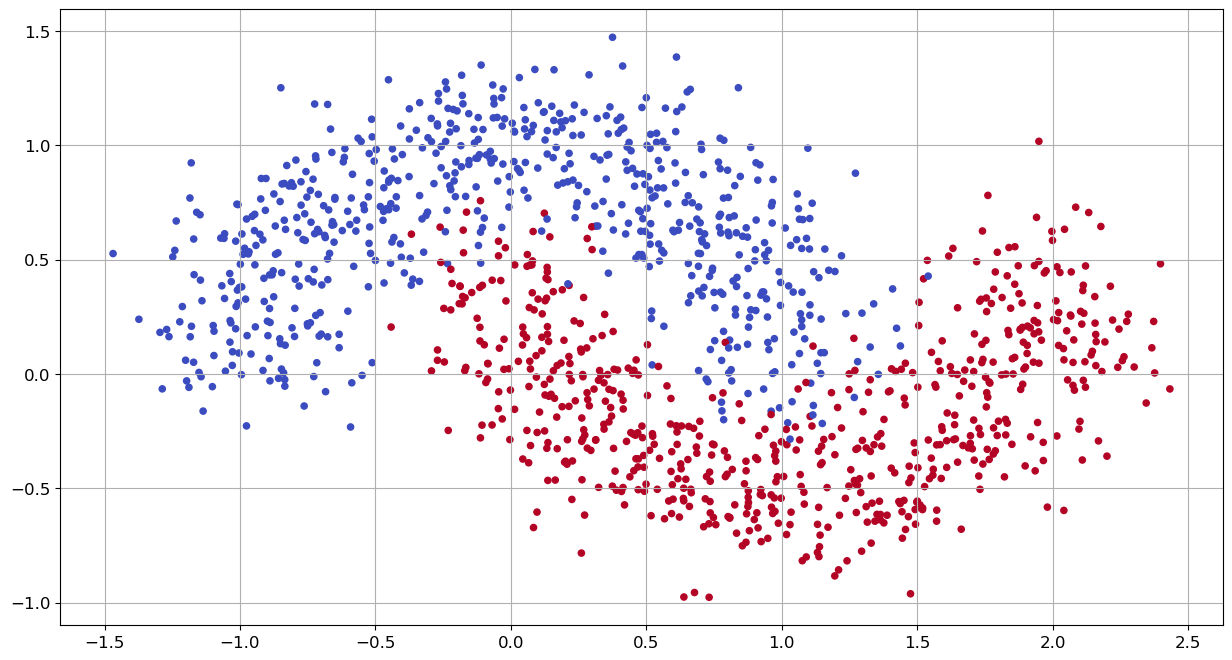

In [8]:
# Plot the data
plt.scatter(X[:,0], X[:,1], s=20, c=y, cmap=CMAP)

plt.grid()

In [9]:
# Make it multiclass data

y = pd.get_dummies(y).to_numpy()
y

array([[False,  True],
       [ True, False],
       [False,  True],
       ...,
       [ True, False],
       [False,  True],
       [ True, False]])

In [10]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1024, 2) (1024, 2) (256, 2) (256, 2)


# Neural Network

## Softmax Function for output layer

In [11]:
def fn_softmax(z : np.ndarray) -> np.ndarray:
    
    '''
    Args:
        z : a matrix of z values of shape (m, n_output)
    returns:
        Softmax values of z
    
    '''
    
    exp_scores = np.exp( z - np.max(z) )

    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

## Activation Function for other layers

In [12]:
def fn_actv(z: np.ndarray) -> np.ndarray:
    
    '''
        Args:
           z : array, Aggregated values 
       Return:
           Activations for each z
    '''

    return np.tanh(z)

def fn_actv_prime(a: np.ndarray) -> np.ndarray:
    '''
        Args:
           a : array, Aggregated values 
       Return:
           Derivative, for each a
    '''

    return 1.0 - np.tanh(a)**2

## Multiple hidden layers

<p style="font-family: Arial; font-size:1.2em;"> 
    Moving over to multilayer network. Our data has <strong>two</strong> features. Hence size of input layer will also be two. The output is binary, we can code it as single column as well as double column output. Let's consider following hidden layers:</p>
<table style="font-family: Arial; font-size:1.2em;">
    <tr>
        <th>#</th>
        <th>Layer Number</th>
        <th>Nodes </th>
        <th>Activation </th>
    </tr>
    <tr>
        <td>1</td>
        <td>Input Layer</td>
        <td>2</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>2</td>
        <td>Hidden Layer 1</td>
        <td>5</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>3</td>
        <td>Hidden Layer 2</td>
        <td>5</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>4</td>
        <td>Hidden Layer 3</td>
        <td>4</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>5</td>
        <td>Hidden Layer 4</td>
        <td>3</td>
        <td>tanh</td>
    </tr>
    <tr>
        <td>6</td>
        <td>Layer 5 (Output)</td>
        <td>2</td>
        <td>softmax</td>
    </tr>
</table>

<img src='../../images/dnn_nb_s06_fig3.png' style='width: 800px' alt = 'dnn_nb_s06_fig3.png'/>

## Loss Function

We need to minimize the error by adjusting ($Ws, bs$). We call the function that measures our error the <b>loss function</b>. A common choice with the softmax output is the cross-entropy loss. The loss for predictions $\hat{y}$ with respect to the true labels $y$ is given by:

$
\begin{aligned}
L(\hat{y_i}, y_i) =  -[y_i.log\hat{y_i} + (1 - y_i) . log(1-\hat{y_i})]
\end{aligned}
$

For all samples:

$
\begin{aligned}
J(\hat{y}, y) =  -\frac{1}{m}\sum_{i=1}^{m}[y_i.log\hat{y}_i + (1-y_i) . log(1-\hat{y}_i)]
\end{aligned}
$


We can use gradient descent to find its minimum. For purpose of this Session, let's use it in its simplest form - <b>batch gradient descent with fixed learning rate</b>.

## Forward Propogation

<img src='../../images/dnn_nb_s06_fig4.png' style='width: 800px' alt = 'Session 6 Figure 4'/>
<br>
                                                               
$
\begin{aligned}
z^{[l]} & = a^{[l-1]} . W^{[l]} + b^{[l]}\\
a^{[l]} & = \text{g}(z^{[l]})\text{ for hidden layers} \\
a^{[l]} & = \mathrm{softmax}(z^{[l]})\text{ for output layer}  \\
\end{aligned}
$

In [13]:
def forward_propagation(model: dict, X: np.ndarray):
    # Extract Weights and biases from the model
    W1, W2, W3, W4, W5 = (model["W1"], model["W2"], model["W3"], 
                          model["W4"], model["W5"])
    
    b1, b2, b3, b4, b5 = (model["b1"], model["b2"], model["b3"], 
                          model["b4"], model["b5"])
    # ***********************************
    # Layer 1
    z1 = X.dot(W1) + b1  # Aggregation
    a1 = fn_actv(z1)  # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2  # Aggregation
    a2 = fn_actv(z2)  # Activation

    # Layer 3
    z3 = a2.dot(W3) + b3  # Aggregation
    a3 = fn_actv(z3)  # Activation

    # Layer 4
    z4 = a3.dot(W4) + b4  # Aggregation
    a4 = fn_actv(z4)  # Activation

    # Layer 5
    z5 = a4.dot(W5) + b5  # Aggregation
    a5 = fn_softmax(z5)  # softmax activation
    # ***********************************

    return {"z1":z1, "a1":a1, 
            "z2":z2, "a2":a2, 
            "a3":z3, "a3":a3, 
            "z4":z4, "a4":a4, 
            "z5":z5, "a5":a5}

## Loss function

In [14]:
def calculate_loss(model: dict, X: np.ndarray, y: np.ndarray) -> np.float64:
    # number of examples
    m = X.shape[0]

    agg = forward_propagation(model, X)

    # Calculating the loss
    data_loss = -(y * np.log(agg['a5']) + (1 - y) * np.log(1 - agg['a5'])).sum()

    return 1.0 / m * data_loss

## Predict Function
<p style="font-family: Arial; font-size:1.2em;">
For predictions, we will simply be using the forward propagation. No need to iterate or calculate the back propogation for supervised learning.
</p>

In [15]:
def predict(model: dict, X: np.ndarray) -> np.ndarray:
    agg = forward_propagation(model, X)
    return np.argmax(agg['a5'], axis=1)

## Backpropogation
#### For last layer
$
\begin{aligned}
\partial{z^{[L]}}  & = a^{[L]} - y \\
\partial{W^{[L]}}  & = \frac{1}{m} a^{[L-1]T}\circ \partial{z^{[L]}} \\
\partial{b^{[L]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[L]}}, axis = 0, keepdims = True) \\
\end{aligned}
$

#### For any other layer
$
\begin{aligned}
\partial{a^{[l]}}  & = \partial{z^{[l+1]}} . \partial{W^{[l+1]T}}\\
\partial{z^{[l]}}  & = \partial{a^{[l]}} * ( 1-a^{[l]}**2)\\
\partial{W^{[l]}}  & = \frac{1}{m} a^{[l-1]T}\circ \partial{z^{[l]}} \\
\partial{b^{[l]}}  & = \frac{1}{m} \mathrm{np.sum}(\partial{z^{[l]}}, axis = 0, keepdims = True) \\
\\
\end{aligned}
$

In [16]:
def backward_propagation(X: np.ndarray, y: np.ndarray, model: dict, agg : dict):
    W1, W2, W3, W4, W5 = (model["W1"], model["W2"], model["W3"], 
                          model["W4"], model["W5"])
    
    a1, a2, a3, a4, a5 = (agg["a1"], agg["a2"], agg["a3"], 
                          agg["a4"], agg["a5"])

    dz5 = a5 - y

    # Layer 5
    dW5 = (a4.T).dot(dz5)
    db5 = np.sum(dz5, axis=0, keepdims=True)  # db5 is vertical sum of dz5
    da4 = dz5.dot(W5.T)

    # Layer 4
    dz4 = da4 * fn_actv_prime(a4)
    dW4 = (a3.T).dot(dz4)
    db4 = np.sum(dz4, axis=0, keepdims=True)
    da3 = dz4.dot(W4.T)

    # Layer 3
    dz3 = da3 * fn_actv_prime(a3)
    dW3 = (a2.T).dot(dz3)
    db3 = np.sum(dz3, axis=0, keepdims=True)
    da2 = dz3.dot(W3.T)

    # Layer 2
    dz2 = da2 * fn_actv_prime(a2)
    dW2 = (a1.T).dot(dz2)
    db2 = np.sum(dz2, axis=0, keepdims=True)
    da1 = dz2.dot(W2.T)

    # Layer 1
    dz1 = da1 * fn_actv_prime(a1)
    dW1 = (X.T).dot(dz1)
    db1 = np.sum(dz1, axis=0, keepdims=True)
    return {
        "dW1": dW1, "db1": db1,
        "dW2": dW2, "db2": db2,
        "dW3": dW3, "db3": db3,
        "dW4": dW4, "db4": db4,
        "dW5": dW5, "db5": db5,
    }

## Build Model

In [17]:
# assemble all parameters in a dictionary object
layer_param = {}
layer_param["nn_hdim"] = [X_train.shape[1], 5, 5, 4, 3]
nn_output_dim = y_train.shape[1]
loss_hist = {}

In [18]:
def build_model(param: dict,
                X : np.ndarray, 
                y : np.ndarray, 
                epochs: np.int64 = EPOCHS, 
                alpha: np.float64 = ALPHA) -> dict:
    
    # number of examples
    m = X.shape[0]
    
    # Initialize the weights and biases to random values. We need to learn these.
    W1 = np.random.randn(param['nn_hdim'][0], param['nn_hdim'][1]) / np.sqrt(param['nn_hdim'][0])
    b1 = np.zeros((1, param['nn_hdim'][1]))
    
    W2 = np.random.randn(param['nn_hdim'][1], param['nn_hdim'][2]) / np.sqrt(param['nn_hdim'][1])
    b2 = np.zeros((1, param['nn_hdim'][2]))
    
    W3 = np.random.randn(param['nn_hdim'][2], param['nn_hdim'][3]) / np.sqrt(param['nn_hdim'][2])
    b3 = np.zeros((1, param['nn_hdim'][3]))
    
    W4 = np.random.randn(param['nn_hdim'][3], param['nn_hdim'][4]) / np.sqrt(param['nn_hdim'][3])
    b4 = np.zeros((1, param['nn_hdim'][4]))
   
    W5 = np.random.randn(param['nn_hdim'][4], nn_output_dim) / np.sqrt(param['nn_hdim'][4])
    b5 = np.zeros((1, nn_output_dim))
    
    model = { 
            'W1': W1, 'b1': b1,
            'W2': W2, 'b2': b2,
            'W3': W3, 'b3': b3,
            'W4': W4, 'b4': b4,
            'W5': W5, 'b5': b5
            }
    
    # lists to collect losses
    curr_loss = 0
    epoch, loss = [],[]
    
    for i in range(0, epochs):
        
        #### Forward ------------------------------
        agg = forward_propagation(model, X)

        
        ### Back Prop ------------------------------
        gradients = backward_propagation(X, y, model, agg)
        dW1, dW2, dW3, dW4, dW5 = (gradients["dW1"], gradients["dW2"], gradients["dW3"], 
                                   gradients["dW4"], gradients["dW5"])
        
        db1, db2, db3, db4, db5 = (gradients["db1"], gradients["db2"], gradients["db3"], 
                                   gradients["db4"], gradients["db5"])
        
        # Weights update
        W1 += -alpha * dW1 /m
        b1 += -alpha * db1 /m
        
        W2 += -alpha * dW2 /m
        b2 += -alpha * db2 /m
        
        W3 += -alpha * dW3 /m
        b3 += -alpha * db3 /m
        
        W4 += -alpha * dW4 /m
        b4 += -alpha * db4 /m
        
        W5 += -alpha * dW5 /m
        b5 += -alpha * db5 /m
        
        model = { 
            'W1': W1, 'b1': b1,
            'W2': W2, 'b2': b2,
            'W3': W3, 'b3': b3,
            'W4': W4, 'b4': b4,
            'W5': W5, 'b5': b5}
        
        if i % 10 == 0:
            curr_loss = calculate_loss (model, X, y)
            loss.append(curr_loss)
            epoch.append(i)
            
            
        # Print the loss.
        if i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, curr_loss))
    
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    
    return model

In [19]:
alpha = ALPHA
epochs = EPOCHS

model = build_model(layer_param, X_train, y_train, epochs, alpha ) 

Loss after iteration 0: 1.229409


Loss after iteration 1000: 0.171101
Loss after iteration 2000: 0.155647
Loss after iteration 3000: 0.146916
Loss after iteration 4000: 0.140580
Loss after iteration 5000: 0.136014
Loss after iteration 6000: 0.133137
Loss after iteration 7000: 0.129957
Loss after iteration 8000: 0.126735
Loss after iteration 9000: 0.124146
Loss after iteration 10000: 0.122517


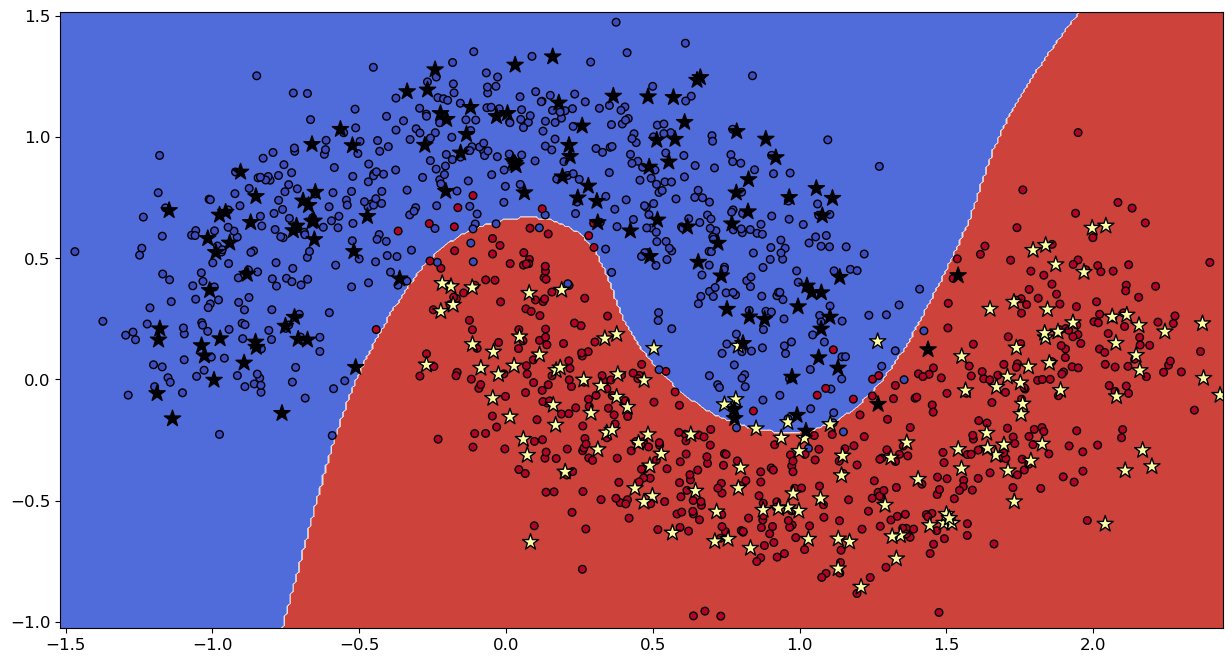

In [20]:
fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train, X_test, y_test) # plot decision boundary for this plot

In [21]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :', accuracy_score(np.argmax(y_train, axis = 1), y_pred))

Accuracy score on Train Data : 0.970703125


In [22]:
print(classification_report(np.argmax(y_train, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       522
           1       0.98      0.96      0.97       502

    accuracy                           0.97      1024
   macro avg       0.97      0.97      0.97      1024
weighted avg       0.97      0.97      0.97      1024



In [23]:
y_pred = predict(model, X_test)

print('Accuracy score on Test Data :', accuracy_score(np.argmax(y_test, axis = 1), y_pred))

Accuracy score on Test Data : 0.9609375


In [24]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       118
           1       0.98      0.95      0.96       138

    accuracy                           0.96       256
   macro avg       0.96      0.96      0.96       256
weighted avg       0.96      0.96      0.96       256



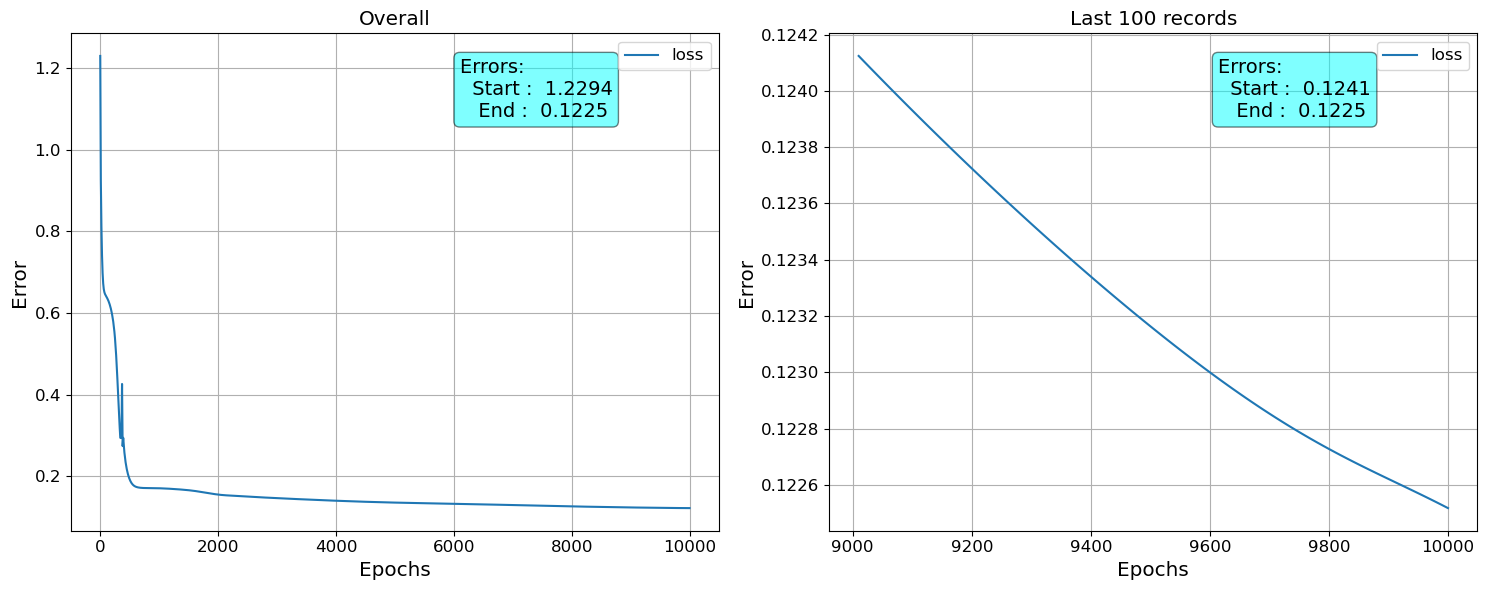

In [25]:
loss_df = pd.DataFrame(loss_hist)

fig, axes = plt.subplots(1,2 , figsize = (15,6))

l_range = 100

ax = axes[0]

loss_df.plot(x = 'epoch', y = 'loss', ax = ax)
loss = loss_df['loss'].values

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[0],loss[-1]) #text to plot

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Overall')
ax.grid();

ax = axes[1]

loss_df[-l_range:].plot(x = 'epoch', y = 'loss', ax = ax)

# little beautification
txtstr = "Errors: \n  Start : {:7.4f}\n   End : {:7.4f}".format(loss[-l_range],loss[-1]) #text to plot

# place a text box in upper left in axes coords

ax.text(0.6, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")
ax.set_title('Last {} records'.format(l_range))
ax.grid();
plt.tight_layout()